<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/1404-07-26-%20arbitrary_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [2]:
# win = 5
# a = np.arange(1, 50, 2, dtype=np.float32)
# print('a =',a)
# b = np.arange(0, 40, 2, dtype=np.float32)   # label 1
# print('b =',b)

In [3]:
win = 2048
t = np.arange(0, 800000, dtype=np.float32)
a = np.sin(0.05*t)                       # class 0
b = np.linspace(0, 1, 800000, dtype=np.float32)
print(b)
# b = np.arange(0, 80000, 2, dtype=np.float32)

[0.0000000e+00 1.2500016e-06 2.5000031e-06 ... 9.9999750e-01 9.9999875e-01
 1.0000000e+00]


In [4]:
def make_windows(data, frame_length, drop_last : bool = True):
    # Calculate how many full frames can be created
    num_frames = len(data) // frame_length
    # print(num_frames)
    # Trim the data to be a perfect multiple of the frame length
    trimmed_data = data[:num_frames * frame_length]

    # Reshape the data into a 2D array of frames
    windows = trimmed_data.reshape((num_frames, frame_length))
    # return trimmed_data.shape , frames.shape
    return windows

In [5]:
# 2) Make windows per class
Xa = make_windows(a, win, drop_last=True)
# print('Xa = \n',Xa)
print(Xa.shape)
Xb = make_windows(b, win, drop_last=True)
# print('Xb = \n', Xb)
print(Xb.shape)

(390, 2048)
(390, 2048)


In [6]:
ya = np.zeros((Xa.shape[0]), dtype=np.int64)
print('ya = ',ya.shape)
yb = np.ones((Xb.shape[0]),  dtype=np.int64)
print('yb = ',yb.shape)

ya =  (390,)
yb =  (390,)


In [7]:
print(Xa)

[[ 0.          0.04997917  0.09983342 ...  0.98903275  0.98041433
   0.96934706]
 [ 0.9558551   0.9399736   0.9217454  ... -0.4317993  -0.47632864
  -0.519681  ]
 [-0.56173426 -0.6023833  -0.6415266  ... -0.7352678  -0.7004829
  -0.66394806]
 ...
 [ 0.6824058   0.71862996  0.7530013  ...  0.6221679   0.5816271
   0.5395868 ]
 [ 0.49954307  0.45492673  0.40913758 ... -0.930569   -0.9479533
  -0.96289355]
 [-0.97535133 -0.98529446 -0.99221855 ... -0.07418173 -0.02346653
   0.02340418]]


In [8]:
print(Xb)

[[0.0000000e+00 1.2500016e-06 2.5000031e-06 ... 2.5562532e-03
  2.5575033e-03 2.5587531e-03]
 [2.5600032e-03 2.5612533e-03 2.5625031e-03 ... 5.1162564e-03
  5.1175063e-03 5.1187566e-03]
 [5.1200064e-03 5.1212562e-03 5.1225065e-03 ... 7.6762596e-03
  7.6775094e-03 7.6787597e-03]
 ...
 [9.9072123e-01 9.9072248e-01 9.9072373e-01 ... 9.9327749e-01
  9.9327874e-01 9.9327999e-01]
 [9.9328125e-01 9.9328250e-01 9.9328375e-01 ... 9.9583751e-01
  9.9583876e-01 9.9584001e-01]
 [9.9584126e-01 9.9584252e-01 9.9584377e-01 ... 9.9839747e-01
  9.9839872e-01 9.9839997e-01]]


In [9]:
n_train = 0.7
n_val = 0.15

m_0 = int(n_train * len(Xa))
l_0 = int(n_val * len(Xa))

m_1 = int(n_train * len(Xb))
l_1 = int(n_val * len(Xb))

X_train_0 = Xa[0:m_0, :]
X_val_0   = Xa[m_0 :m_0+l_0, :]
X_test_0  = Xa[m_0+l_0:, :]

X_train_1 = Xb[0:m_1, :]
X_val_1   = Xb[m_1 :m_1+l_1, :]
X_test_1  = Xb[m_1+l_1:, :]

In [10]:
print(X_train_0)
print('val:\n',X_val_0)
print(X_test_0)

[[ 0.          0.04997917  0.09983342 ...  0.98903275  0.98041433
   0.96934706]
 [ 0.9558551   0.9399736   0.9217454  ... -0.4317993  -0.47632864
  -0.519681  ]
 [-0.56173426 -0.6023833  -0.6415266  ... -0.7352678  -0.7004829
  -0.66394806]
 ...
 [ 0.91557854  0.8939859   0.87104946 ... -0.5329565  -0.57521915
  -0.6144591 ]
 [-0.6537136  -0.6912827  -0.7257272  ... -0.65189147 -0.6125596
  -0.57324994]
 [-0.5309197  -0.4889253  -0.44401628 ...  0.9165432   0.93497115
   0.95177144]]
val:
 [[ 0.9661179   0.97756404  0.98699576 ...  0.11257817  0.06394555
   0.01320758]
 [-0.03561263 -0.08629396 -0.1367528  ... -0.98314553 -0.9725981
  -0.95954305]
 [-0.9446568  -0.92678684 -0.9073503  ...  0.46398485  0.5083517
   0.5497774 ]
 ...
 [-0.41883248 -0.46438536 -0.50874096 ... -0.83624446 -0.8073322
  -0.7763385 ]
 [-0.74334323 -0.7084315  -0.674582   ...  0.77136326  0.8026719
   0.82973725]
 [ 0.8569992   0.8820517   0.9048301  ...  0.38309035  0.33570948
   0.2874631 ]]
[[ 0.23847558  0

In [11]:
print(X_train_1)
print('val:\n',X_val_1)
print(X_test_1)

[[0.0000000e+00 1.2500016e-06 2.5000031e-06 ... 2.5562532e-03
  2.5575033e-03 2.5587531e-03]
 [2.5600032e-03 2.5612533e-03 2.5625031e-03 ... 5.1162564e-03
  5.1175063e-03 5.1187566e-03]
 [5.1200064e-03 5.1212562e-03 5.1225065e-03 ... 7.6762596e-03
  7.6775094e-03 7.6787597e-03]
 ...
 [6.9120085e-01 6.9120210e-01 6.9120336e-01 ... 6.9375712e-01
  6.9375837e-01 6.9375962e-01]
 [6.9376087e-01 6.9376212e-01 6.9376338e-01 ... 6.9631714e-01
  6.9631839e-01 6.9631964e-01]
 [6.9632089e-01 6.9632214e-01 6.9632339e-01 ... 6.9887710e-01
  6.9887835e-01 6.9887960e-01]]
val:
 [[0.69888085 0.6988821  0.69888335 ... 0.7014371  0.70143837 0.7014396 ]
 [0.7014409  0.7014421  0.7014434  ... 0.70399714 0.7039984  0.70399964]
 [0.7040009  0.70400214 0.7040034  ... 0.70655715 0.7065584  0.70655966]
 ...
 [0.839681   0.8396823  0.83968353 ... 0.8422373  0.84223855 0.8422398 ]
 [0.84224105 0.8422423  0.84224355 ... 0.8447973  0.84479856 0.8447998 ]
 [0.84480107 0.8448023  0.8448036  ... 0.84735733 0.8473586 

In [12]:
X_train = np.vstack([X_train_0, X_train_1])[:, :, None]  # [N, 5, 1]
print(X_train.shape)

y_train = np.concatenate([ya[0:int(len(X_train_0))], yb[0:int(len(X_train_1))]])             # [N]
print(y_train)
print(y_train.shape)

(546, 2048, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1

In [13]:
print(ya)
print(yb)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [14]:
X_val =  np.vstack([X_val_0, X_val_1])[:, :, None]  # [N, 5, 1]
print(X_val.shape)
# print(X)
print(int(len(X_train_0)))
print(int( len(X_train_0)+len(X_val_0)))
print(ya[int(len(X_train_0)): int(len(X_train_0)+len(X_val_0))])

print(int(len(X_train_1)))
print(int(len(X_train_1) + len(X_val_1)))

y_val = np.concatenate([ya[int(len(X_train_0)): int(len(X_train_0) + len(X_val_0))], yb[int(len(X_train_1)): int(len(X_train_1) + len(X_val_1))]])             # [N]
print(y_val.shape) # Corrected to print y_val shape
print(y_val)

(116, 2048, 1)
273
331
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
273
331
(116,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


In [15]:
X_test =  np.vstack([X_test_0, X_test_1])[:, :, None]  # [N, 5, 1]
print(X_test.shape)
# print(X)
y_test = np.concatenate([ya[int(len(X_train_0) + len(X_val_0)):], yb[int(len(X_train_1) + len(X_val_1)):]], axis=0)             # [N]
print(y_test)
print(y_test.shape) # Corrected to print y_val shape

(118, 2048, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
(118,)


In [16]:
# 5) Torch tensors
X_train = torch.from_numpy(X_train).float()  # float32
y_train = torch.from_numpy(y_train).long()  # int64
X_val   = torch.from_numpy(X_val).float()
y_val   = torch.from_numpy(y_val).long()
X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()

In [17]:
mu  = X_train.mean(axis=(0), keepdims=True)
std = X_train.std(axis=(0), keepdims=True) + 1e-6
X_train = (X_train - mu) / std
X_val   = (X_val   - mu) / std
X_test  = (X_test  - mu) / std

In [18]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([546, 2048, 1]) torch.Size([546])
torch.Size([116, 2048, 1]) torch.Size([116])
torch.Size([118, 2048, 1]) torch.Size([118])


In [19]:
class SeqDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X  # [N, seq_len, 1]
        self.y = y  # [N]
    def __len__(self): return self.y.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
# print(X_train.shape)
# print(train_ds[0])
# print(train_ds[1])
# print(train_ds[2])
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

In [20]:
# 6) DataLoaders: shuffle only the training set
batch_size = 512
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# tiny = 200
# train_loader = DataLoader(SeqDataset(X_train[:tiny], y_train[:tiny]),batch_size=50, shuffle=True)

# print('ppp',next(iter(train_loader)))

In [21]:
# 7) Example: adapt a batch for a Transformer [seq_len, batch, d_model]
xb, yb = next(iter(train_loader))   # xb: [B, 5, 1]
# xb_t = xb.transpose(0, 1)           # -> [5, B, 1]
# print("Shapes:", xb.shape, xb_t.shape, yb.shape)

In [22]:
class LearnablePositionalEncoding(nn.Module):
    """
    Learnable positional encoding added to token embeddings.
    Shape stored: [1, max_len, d_model]
    """
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        print(self.pe)
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [23]:
 pe = LearnablePositionalEncoding(d_model=3, max_len=5)
#  print(pe(batch_X[0]))

Parameter containing:
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], requires_grad=True)


In [24]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=64, nhead=2, num_layers=2, d_ff=256, seq_len=5, num_classes=2, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(1, d_model)                            # project feature_dim=1 -> d_model
        self.pos = LearnablePositionalEncoding(d_model, seq_len)    # learnable PE
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True                                        # so we keep [B, T, d]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, T, 1]
        x = self.inp(x)                  # [B, T, d]
        x = self.pos(x)                  # add learnable PE
        x = self.encoder(x)              # [B, T, d]
        x = self.norm(x)
        x = x.mean(dim=1)                # mean pool over time
        logits = self.head(x)            # [B, C]
        return logits

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_len = X_train.shape[1]
num_classes = 2
model = TimeSeriesTransformer(d_model=64, nhead=2, num_layers=2, d_ff=256,seq_len=seq_len, num_classes=num_classes).to(device)

Parameter containing:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)


In [26]:
# Optional class weights for CE or focal alpha; compute from training labels
class_counts = torch.bincount(y_train)
class_weights = (class_counts.sum() / (class_counts.float().clamp(min=1)))  # inverse freq
class_weights = class_weights / class_weights.sum() * num_classes           # normalize
class_weights = class_weights.to(device)

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# loss = nn.BCELoss() # BCELoss = no sigmoid built-in
# loss = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

In [28]:
num_epochs = 50
tr_losses = []
tr_accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
     model.train()
     total_loss = 0
     total_samples = 0
     correct_predictions = 0
     for xb, yb in train_loader:
        xb , yb = xb.to(device) , yb.to(device).long()
        optimizer.zero_grad()
        output = model(xb)
        # print('output',output)
        # print('max',torch.max(output, 1))
        # print('yb',yb)

        loss = loss_fn(output , yb)
        # print('loss',loss)
        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        # print(loss.item())
        # print(xb.size(0))
        # print('total:',total_loss)

        # Calculate accuracy
        pred = output.argmax(dim=1) # the index of the maximum value for each column
        # print('p',predicted)
        # print('real',yb)
        total_samples += xb.size(0)
        # print(total_samples)
        correct_predictions += (pred == yb).sum().item()
        # print(correct_predictions)

     epoch_loss = total_loss / total_samples
     epoch_accuracy = correct_predictions / total_samples
     tr_losses.append(epoch_loss)
     tr_accs.append(epoch_accuracy)

    #  print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f}")

     model.eval()
     val_correct_predictions = 0
     val_total_samples = 0
     val_total_loss = 0
     with torch.no_grad():
          for xb, yb in val_loader:
              xb, yb = xb.to(device), yb.to(device).long()
              output = model(xb)
              val_loss = loss_fn(output,yb)
              val_total_loss += val_loss.item() * xb.size(0)
              pred = output.argmax(dim=1)
              val_total_samples += xb.size(0)
              val_correct_predictions += (pred == yb).sum().item()

     val_epoch_loss = val_total_loss / val_total_samples
     val_epoch_accuracy = val_correct_predictions / val_total_samples
    #  print(    f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")
     val_losses.append(val_epoch_loss)
     val_accs.append(val_epoch_accuracy)
     print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f} | "f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")





Epoch 1/50: Train Loss: 0.8591, Train Accuracy: 0.5000 | Validation Loss: 0.5720, Validation Accuracy: 1.0000

Epoch 2/50: Train Loss: 0.5875, Train Accuracy: 0.9267 | Validation Loss: 0.3721, Validation Accuracy: 1.0000

Epoch 3/50: Train Loss: 0.4326, Train Accuracy: 1.0000 | Validation Loss: 0.2270, Validation Accuracy: 1.0000

Epoch 4/50: Train Loss: 0.3023, Train Accuracy: 1.0000 | Validation Loss: 0.1285, Validation Accuracy: 1.0000

Epoch 5/50: Train Loss: 0.1959, Train Accuracy: 1.0000 | Validation Loss: 0.0697, Validation Accuracy: 1.0000

Epoch 6/50: Train Loss: 0.1180, Train Accuracy: 1.0000 | Validation Loss: 0.0366, Validation Accuracy: 1.0000

Epoch 7/50: Train Loss: 0.0673, Train Accuracy: 1.0000 | Validation Loss: 0.0202, Validation Accuracy: 1.0000

Epoch 8/50: Train Loss: 0.0378, Train Accuracy: 1.0000 | Validation Loss: 0.0122, Validation Accuracy: 1.0000

Epoch 9/50: Train Loss: 0.0214, Train Accuracy: 1.0000 | Validation Loss: 0.0080, Validation Accuracy: 1.0000

E

In [29]:
import torch.nn.functional as F
val_probs = []
val_true  = []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        val_probs.append(F.softmax(out, dim=1).max(1).values.cpu())
        val_true.append(yb)
val_probs = torch.cat(val_probs)
print('Val avg max-softmax:', val_probs.mean().item())


Val avg max-softmax: 0.9993705749511719


In [30]:
model.eval()
import torch.nn.functional as F
probs = []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        p = F.softmax(out, dim=1).max(dim=1).values
        probs.append(p.cpu())
probs = torch.cat(probs)
print("Val avg max softmax:", probs.mean().item())


Val avg max softmax: 0.9993705749511719


In [31]:
# =========================
# Test evaluation (add this)
# =========================
model.eval()
test_correct = 0
test_total = 0
test_loss_total = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device).long()
        out = model(xb)
        loss = loss_fn(out, yb)
        test_loss_total += loss.item() * xb.size(0)
        pred = out.argmax(dim=1)
        test_correct += (pred == yb).sum().item()
        test_total += xb.size(0)

print(f"Test Loss: {test_loss_total/test_total:.4f}, Test Acc: {test_correct/test_total:.4f}")


Test Loss: 0.0006, Test Acc: 1.0000


In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        all_pred.append(out.argmax(1).cpu().numpy())
        all_true.append(yb.numpy())
cm = confusion_matrix(np.concatenate(all_true), np.concatenate(all_pred))
print(cm)


[[58  0]
 [ 0 58]]


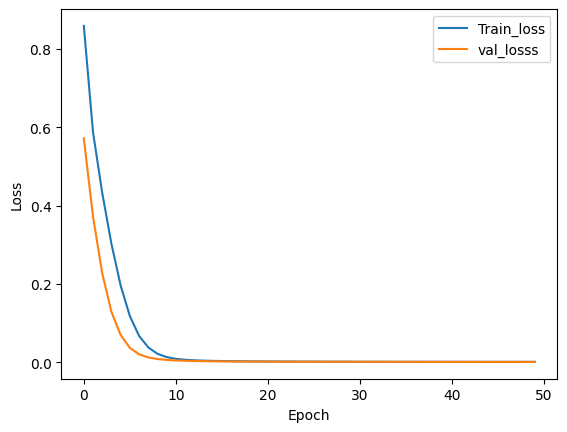

In [33]:
epoch = np.arange(0,num_epochs , 1)
import matplotlib.pyplot as plt

plt.plot(epoch, tr_losses , label="Train_loss")
plt.plot(epoch, val_losses, label="val_losss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

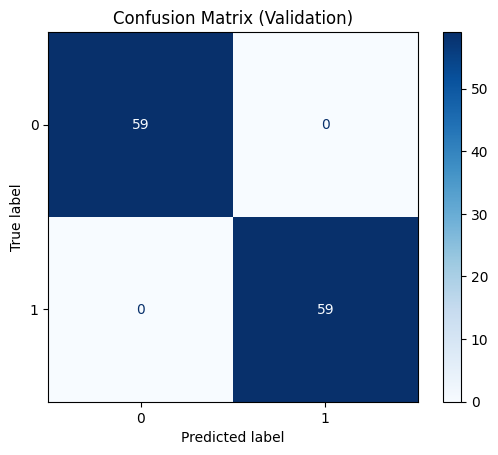

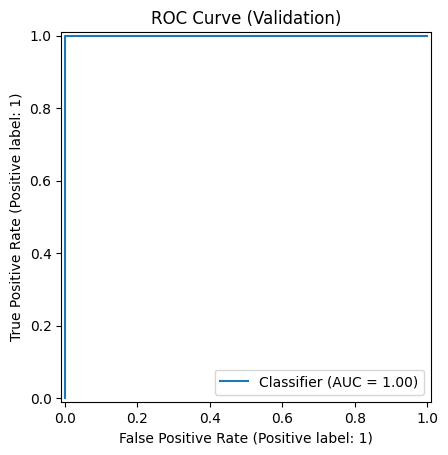

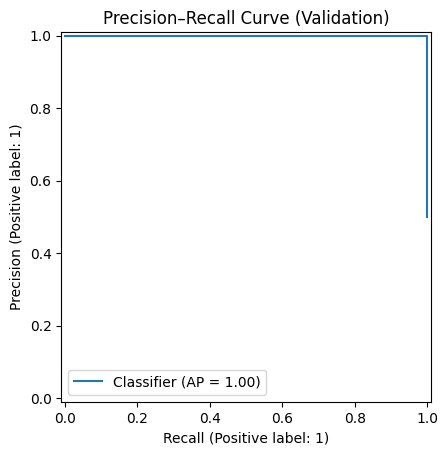

In [34]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred, y_score = [], [], []
model.eval()

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device).long()   # targets should be int for CE
        logits = model(xb)                             # [B,2]

        # 1) Probability of class 1
        probs  = torch.softmax(logits, dim=1)          # [B,2]
        score1 = probs[:, 1]                           # [B]

        # 2) Predicted class index
        preds  = logits.argmax(dim=1)                  # [B]

        # Save results
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        y_score.extend(score1.cpu().tolist())

# 1) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

# 2) ROC
RocCurveDisplay.from_predictions(y_true, y_score)
plt.title("ROC Curve (Validation)")
plt.show()

# 3) Precision–Recall
PrecisionRecallDisplay.from_predictions(y_true, y_score)
plt.title("Precision–Recall Curve (Validation)")
plt.show()

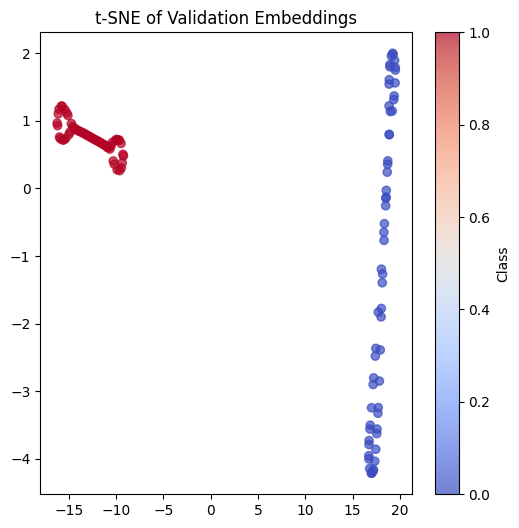

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

model.eval()
all_embeds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Pass through encoder only (skip classifier head)
        embeds = model.encoder(model.inp(xb) + model.pos(model.inp(xb)))
        embeds = embeds.mean(dim=1)                # [B, d_model]

        all_embeds.append(embeds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_embeds = torch.cat(all_embeds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=all_labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE of Validation Embeddings")
plt.show()
